# Initial experiments with Toeplitz matrices

Some initial experiments autoencoding with toeplitz matrices for one training example, as well as doing matrix factorization with toeplitz matrices.

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import train_utils as train
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in l

# Autoencoder

In [2]:
class ToeplitzLayer(train.BaseLayer):
    def __init__(self, n, init_val, init_vec=None):
        
        super(ToeplitzLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(2*n -1)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))
        
    def forward(self, input):
        return torch.stack([F.linear(self.weight.narrow(0, self.n-1-i,self.n), input) for i in range(self.n)], dim=1)
    
    def weight_matrix(self):
        return torch.stack([self.weight.narrow(0, self.n-1-i,self.n) for i in range(self.n)])
                            
class DeepToeplitz(train.DeepNet):
    def __init__(self, n, depth, init_vec=None):
        
        super(DeepToeplitz, self).__init__(n, depth)

        init_vals = {2: 1e-9, 3: 1e-2, 4: 1e-1, 5: 1e-1, 6: 1e-1}
        if init_vec is None:
            self.layers = nn.ModuleList([ToeplitzLayer(n, init_vals[self.depth]) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([ToeplitzLayer(n, 0.0, init_vec=init_vec) for i in range(depth)])

In [3]:
n = 4
x = torch.rand(1, n)
data = x.reshape(-1, 1).detach().numpy()
pinv = np.matmul(data, np.linalg.pinv(data))

In [5]:
svd = []
all_svals = []
nets = []
align = []
losses = []

for depth in range(2, 7):
    print("\ndepth = " + str(depth))
    toep = DeepToeplitz(n, depth)
    l, a, svals = train.train(toep, x, 1e-8)
    all_svals.append(svals)
    losses.append(l)
    align.append(a)
    nets.append(toep)
    weight = toep.weight_matrix().detach().numpy()
    svd.append(np.linalg.svd(weight)[1])



depth = 2
0.24120870232582092


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys



depth = 3
0.24120855331420898
0.2412060797214508
0.0007770328084006906

depth = 4
0.24127189815044403

depth = 5
0.24120493233203888
0.2411966323852539
0.2411687970161438
0.23492023348808289

depth = 6
0.24121473729610443
0.2412022203207016
0.24117057025432587
0.15480589866638184


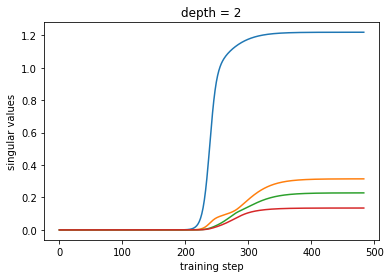

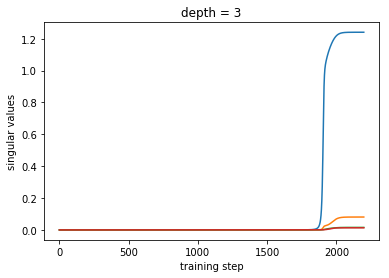

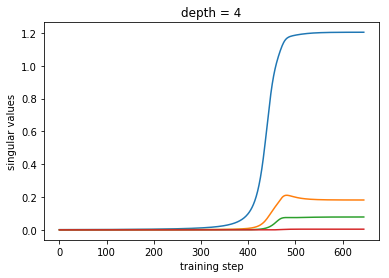

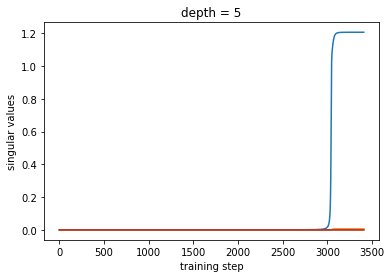

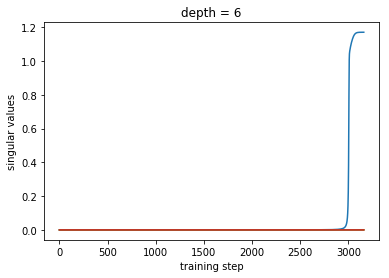

In [6]:
for i in range(5):
    plt.plot(all_svals[i])
    plt.xlabel("training step")
    plt.ylabel("singular values")
    plt.title("depth = " + str(i+2))
    plt.show()

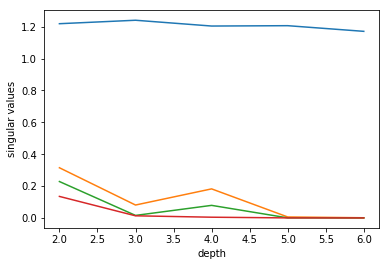

In [7]:
for i in range(4):
    plt.plot(range(2, 7), [j[i] for j in svd])
plt.xlabel("depth")
plt.ylabel("singular values")
plt.show()

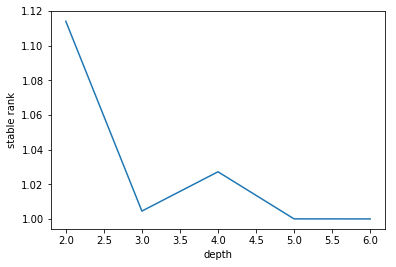

In [8]:
plt.plot(range(2,7), [train.stable_rank(j) for j in svd])
plt.xlabel("depth")
plt.ylabel("stable rank")
plt.show()

In [10]:
# print singular vals
for i in range(5): # only look at nets past a certain depth 
    print("depth = ", i+2)
    for layer in nets[i].layers:
        print(np.linalg.svd(layer.weight_matrix().detach().numpy())[1])

depth =  2
[ 1.36627638  0.54010946  0.50573772  0.35985625]
[ 0.95894092  0.61142409  0.56217253  0.26703063]
depth =  3
[ 1.34412861  0.41722009  0.24352667  0.20238227]
[ 1.32603061  0.40816528  0.21689571  0.16961882]
[ 0.84378487  0.56004834  0.44761238  0.17910552]
depth =  4
[ 1.06494403  0.64629573  0.3943857   0.27358875]
[ 1.3952297   0.95707887  0.5237903   0.20840366]
[ 1.12997842  1.05241203  0.52214795  0.15833075]
[ 1.19811344  0.81989872  0.69432873  0.10595192]
depth =  5
[ 1.17390442  0.42254189  0.29964778  0.23238961]
[ 1.19379544  0.40204406  0.16908611  0.11148819]
[ 1.18699551  0.37673515  0.06966931  0.05549321]
[ 1.02270341  0.24699847  0.14885876  0.13393575]
[ 0.86423051  0.67960894  0.57660156  0.33876646]
depth =  6
[ 1.10902953  0.25298283  0.17416666  0.10224248]
[ 1.18594885  0.63483524  0.18249358  0.15154941]
[ 1.17707694  0.40912017  0.20789357  0.18009157]
[ 1.15184796  0.29071778  0.14644891  0.03910267]
[ 1.12318194  0.23709756  0.19810975  0.19554

In [14]:
def alignment(net):
    u_vals = []
    vh_vals = []
    for layer in net.layers:
        u, s, vh = np.linalg.svd(layer.weight_matrix().detach().numpy())
        u_vals.append(u)
        vh_vals.append(vh)
#         print(u)
#         print(vh.transpose())
    return sum([abs(np.dot(u_vals[i].transpose()[0], vh_vals[i+1][0])) for i in range(len(net.layers) - 1)])/float(len(net.layers) - 1)
alignment(toep)
# np.linalg.eig(al)

1.0

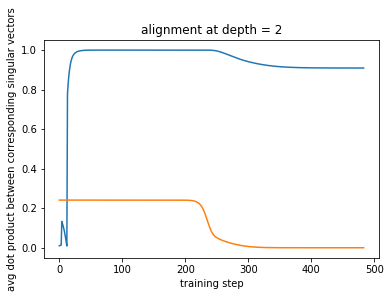

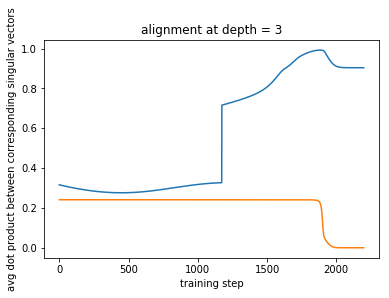

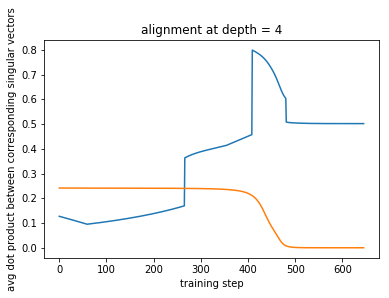

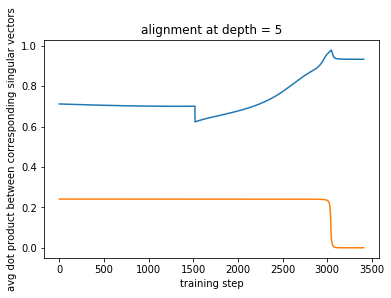

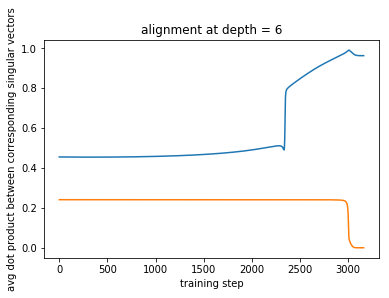

In [11]:
for i in range(len(align)):
    plt.title("alignment at depth = " + str(i + 2))
    plt.plot(align[i])
    plt.plot(losses[i])
    plt.ylabel("avg dot product between corresponding singular vectors")
    plt.xlabel("training step")
    plt.show()

In [33]:
# GOAL: Initialize each toeplitz layer to be the SAME, and see if alignment persists throughout training
align = []
depth = 6
n = 4

# initialize symmetric toeplitz matrix
rand = 0.1*np.random.normal(size=n)
init_vec = np.zeros(2*n - 1)

for i in range(n):
    init_vec[i] = rand[i]
    init_vec[2*n - 2 - i] = rand[i]

toep = DeepToeplitz(n, depth, init_vec = init_vec)

# initialize data to get data alignment

x = torch.tensor(np.linalg.svd(toep.layers[0].weight_matrix().detach().numpy())[2][0].reshape(1, n))

In [34]:
# verify layers are symmetric
toep.layers[1].weight_matrix()

tensor([[ 0.0994, -0.1404, -0.0478,  0.0299],
        [-0.1404,  0.0994, -0.1404, -0.0478],
        [-0.0478, -0.1404,  0.0994, -0.1404],
        [ 0.0299, -0.0478, -0.1404,  0.0994]], grad_fn=<StackBackward>)

In [35]:
losses, align, svals = train.train(toep, x, 1e-12)

0.24975651502609253


In [78]:
# layers are not necessarily symmetric since not forced to be:
toep.layers[2].weight_matrix()

tensor([[-0.4779,  0.2252,  0.1545, -0.3503],
        [ 0.2252, -0.4779,  0.2252,  0.1545],
        [ 0.1545,  0.2252, -0.4779,  0.2252],
        [-0.3503,  0.1545,  0.2252, -0.4779]], grad_fn=<StackBackward>)

(0.99, 1.001)

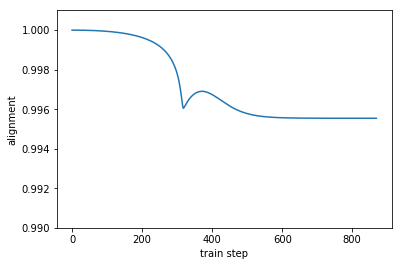

In [38]:
# alignment is not an invariant:
plt.ylabel("alignment")
plt.xlabel("train step")
plt.plot(align)
plt.ylim(0.99, 1.001)

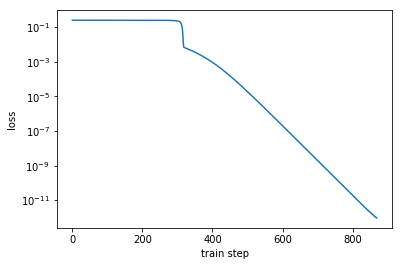

In [39]:
plt.ylabel("loss")
plt.xlabel("train step")
plt.plot(losses)
plt.yscale("log")

# Symmetric Toeplitz

In [40]:
# Now we FORCE each layer to be symmetric and toeplitz
class SymToeplitzLayer(train.BaseLayer):
    def __init__(self, n, init_val, init_vec=None):
        
        super(SymToeplitzLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(n)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))
        
    def forward(self, input):
        return torch.stack([F.linear(torch.cat([torch.flip(self.weight.narrow(0, 1, i), dims=[0]), 
                                                self.weight.narrow(0, 0,self.n-i)]), input) 
                            for i in range(self.n)], dim=1)
    
    def weight_matrix(self):
        return torch.stack([torch.cat([torch.flip(self.weight.narrow(0, 1, i), dims=[0]),
                                       self.weight.narrow(0, 0,self.n-i)]) 
                            for i in range(self.n)], dim = 1)
                            
class DeepSymToeplitz(train.DeepNet):
    def __init__(self, n, depth, init_vec=None):
        
        super(DeepSymToeplitz, self).__init__(n, depth)

        init_vals = {2: 1e-9, 3: 1e-2, 4: 1e-1, 5: 1e-1, 6: 1e-1}
        if init_vec is None:
            self.layers = nn.ModuleList([SymToeplitzLayer(n, init_vals[self.depth]) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([SymToeplitzLayer(n, 0.0, init_vec=init_vec) for i in range(depth)])

In [11]:
n = 4
x = torch.rand(1, n)

In [12]:
svd = []
all_svals = []
nets = []
align = []
losses = []

for depth in range(2, 4):
    print("\ndepth = " + str(depth))
    toep = DeepSymToeplitz(n, depth)
    l, a, svals = train.train(toep, x, 1e-8)
    all_svals.append(svals)
    losses.append(l)
    align.append(a)
    nets.append(toep)
    weight = toep.weight_matrix().detach().numpy()
    svd.append(np.linalg.svd(weight)[1])


depth = 2
0.25105756521224976


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


1.760393843142083e-06

depth = 3
0.25105708837509155
0.008610526099801064


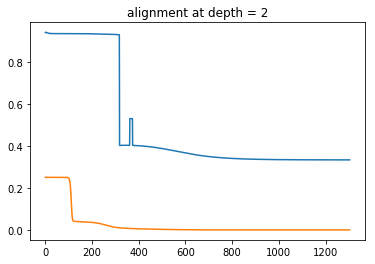

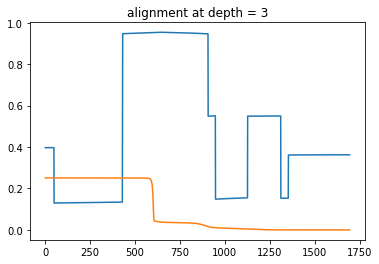

In [13]:
for i in range(len(align)):
    plt.title("alignment at depth = " + str(i + 2))
    plt.plot(align[i])
    plt.plot(losses[i])
    plt.show()

In [62]:
# GOAL: Initialize each symmetric toeplitz layer to be the SAME, and see if alignment persists throughout training
align = []
depth = 6

# initialize symmetric toeplitz matrix
init_vec = 0.1*np.random.normal(size=n)

toep = DeepSymToeplitz(n, depth, init_vec = init_vec)

# initialize data to get data alignment

x = torch.tensor(np.linalg.svd(toep.layers[0].weight_matrix().detach().numpy())[2][0].reshape(1, n))

losses, align, svals = train.train(toep, x, 1e-12)

0.24988529086112976


In [44]:
# verify still symmetric
toep.layers[2].weight_matrix()

tensor([[ 0.3570,  0.2377, -0.2563, -0.3541],
        [ 0.2377,  0.3570,  0.2377, -0.2563],
        [-0.2563,  0.2377,  0.3570,  0.2377],
        [-0.3541, -0.2563,  0.2377,  0.3570]], grad_fn=<StackBackward>)

Text(0.5,0,'train step')

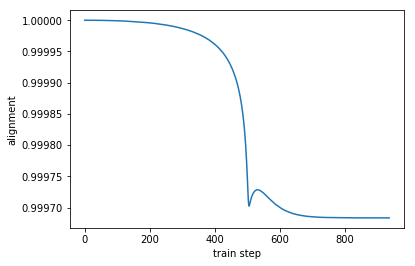

In [63]:
plt.plot(align)
plt.ylabel("alignment")
plt.xlabel("train step")

Text(0.5,0,'train step')

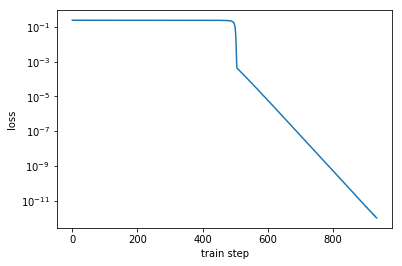

In [64]:
plt.plot(losses)
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("train step")

#### Factorization

In [19]:
# A is an input matrix we're trying to factor
def toeplitz_factor(A, depth):
    size = len(A)
    toep = DeepToeplitz(size, depth)
    optimizer = optim.SGD(toep.parameters(), lr = 0.1)
    criterion = nn.MSELoss()
    init = toep.weight_matrix()
    loss_val = 1
    data = [np.array([1. if i == j else 0. for i in range(size)]) for j in range(size)]

    y = torch.Tensor([np.matmul(A, x) for x in data]).view(len(data), size)
    x = torch.Tensor(data).view(len(data), size)
    i = 0

    while loss_val > 1e-8:
        optimizer.zero_grad()
        pred = toep(x)
        loss = criterion(y, pred)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            loss_val = loss.data.item()
            print(loss_val)
        i += 1
    return [i.weight_matrix().detach().numpy() for i in toep.layers], x, y, toep

In [20]:
size = 8
depth = 6 # depth should be >= floor(size/2) + 1
A = np.random.randn(size, size)
factors, x, y, toep = toeplitz_factor(A, depth)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


1.0939550399780273
1.0934993028640747
0.08191149681806564
0.006480779033154249
0.006118638440966606
0.005167653784155846
0.004347993992269039
0.0036249307449907064
0.003077788045629859
0.0026008146815001965
0.002200288698077202
0.001876959577202797
0.0016212200280278921
0.0014187151100486517
0.0012555536814033985
0.0011216102866455913
0.001008721999824047
0.000911838433239609
0.0008270514663308859
0.0007517045014537871
0.0006840329151600599
0.0006228425772860646
0.0005672092083841562
0.0005164595786482096
0.00046997476601973176
0.00042728084372356534
0.00038839218905195594
0.00035254828981123865
0.0003197896294295788
0.0002897947560995817
0.0002622931497171521
0.00023721536854282022
0.00021434258087538183
0.00019346410408616066
0.00017445688717998564
0.00015717829228378832
0.00014154770178720355
0.00012739369412884116
0.00011450080637587234
0.0001028832484735176
9.2375572421588e-05
8.291538688354194e-05
7.437748718075454e-05
6.673349707853049e-05
5.981949288980104e-05
5.355294706532731

In [21]:
print("A =\n", A)
print("factors = ")
for i in factors:
    print(i)
res = np.eye(len(A))
for i in factors:
    res = np.matmul(i, res)
print("result =\n", res)
print(np.linalg.norm(A - res))

A =
 [[ 0.35054828 -0.17568773 -0.15782313 -1.21552867 -0.34747609  0.97748717
   0.25545511 -0.15800801]
 [-1.25984842 -0.36832927 -0.27884005  1.2679355  -0.51307343 -0.42047946
   1.42834476 -0.29956263]
 [-0.42433492  0.05072407  0.58116082  0.9964613   0.30398447  0.95309068
  -1.64761871 -2.50971319]
 [ 0.05843817 -0.84068726 -1.42935858 -0.44080399 -0.92907023 -1.36036247
  -0.60361811 -0.63378867]
 [-0.1591984   1.8777438   1.16093289 -0.26627297  0.96904973 -0.03356326
  -0.51081243 -2.76575777]
 [-0.57603175 -0.60828428 -1.24359267 -0.58098698 -0.12056569 -0.91894361
  -0.12879153 -0.12626046]
 [-1.59067656  0.13796452  1.15330147  0.36051114 -1.20276213 -0.3779391
  -2.08922747 -0.86302033]
 [ 3.41526611 -0.31730039  0.47553042 -1.65487002 -0.29141774  0.04702958
   0.45931801  0.47741582]]
factors = 
[[-0.16029082  0.64350915 -0.58997285  0.8711344   0.08250342  0.37680534
   0.09908661 -0.68248045]
 [-0.34792262 -0.16029082  0.64350915 -0.58997285  0.8711344   0.08250342
 